In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymc3 as pm
from theano import tensor as tt

In [25]:
with open("CMPs.csv", 'r') as fh:
    cmps = np.loadtxt(fh, delimiter=',')
np.shape(cmps)

(20, 10000)

In [21]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining
k = 20
m = pm.Model()
with m:
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=k)
    pi = pm.Deterministic('pi', stick_breaking(beta))

    tau = pm.Gamma('tau', 1, 1, shape=k) 
    lambda_ = pm.Uniform('lambda', 0, 1, shape=k)
    mu0 = pm.Uniform('mu0', -3, 3, shape=k)
    
    mu = pm.Normal('mu', mu=mu0, tau=1, shape=k)
    obs = pm.NormalMixture('obs', w=pi, mu=mu, tau=lambda_ * tau, observed=cmps.T)

INFO (theano.gof.compilelock): Refreshing lock /Users/darius/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/lock_dir/lock


In [26]:
with m: 
    trace = pm.sample(2000, tune=2000, init='advi', random_seed=35171)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -28,354:  27%|██▋       | 54999/200000 [07:41<20:16, 119.17it/s] 
Convergence achieved at 55000
Interrupted at 54,999 [27%]: Average Loss = -17,703
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, mu0, lambda, tau, beta, alpha]
Sampling 2 chains, 1,854 divergences: 100%|██████████| 8000/8000 [14:05<00:00,  9.46draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/darius/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/lock_dir/lock
There were 891 divergences after tuning. Increase `target_accept` or reparameterize.
There were 963 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


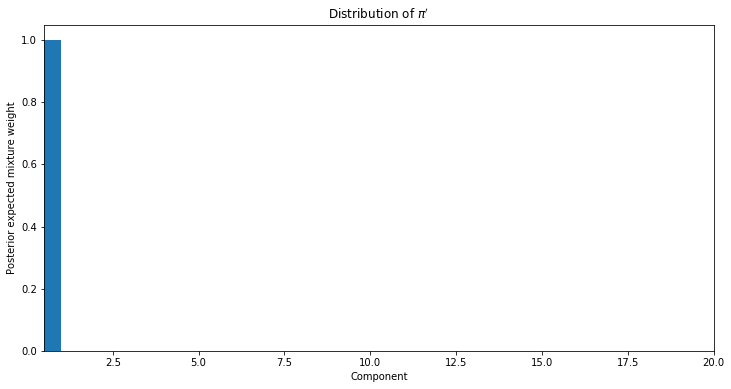

In [27]:
plt.figure(figsize=(12, 6))
plt.title(r"Distribution of $\pi'$")
plt.bar(np.arange(k) + 1 - 0.5, trace['pi'].mean(axis=0), width=1., lw=0);
plt.xlim(0.5, k);
plt.xlabel('Component');
plt.ylabel('Posterior expected mixture weight');

In [47]:
final = np.zeros(np.shape(cmps))
def hellinger3(p, q):
    _SQRT2 = np.sqrt(2) 
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

55.96753599494305

In [91]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import *
fn = braycurtis
final = np.zeros((1000, 1000))
for i, v1 in enumerate(cmps.T[0:1000,:]):
    for j, v2 in enumerate(cmps.T[0:1000,:]):
        final[i,j] = fn(v1, v2)
clustering = DBSCAN(eps=0.01, min_samples=np.shape(cmps)[1] / 100).fit(cmps.T)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0]), array([  44, 9956]))

0.0001086733747350634

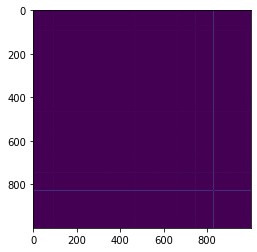

In [96]:
plt.imshow(final)
np.median(final)